In [3]:
import os
import scipy.io as spio
import numpy as np
from os.path import join, isdir, isfile
%matplotlib inline
import matplotlib.pyplot as plt
import sys, itertools
from joblib import Parallel, delayed
from sklearn.svm import SVC
import sklearn, warnings
import time, math

warnings.filterwarnings('ignore')

# from stack overflow
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

# 'file_name' 'class_name' 'class' 'eng' 'mfc' 'chroma' 't'
# 'keystrength' 'brightness' 'zerocross' 'roughness' 'inharmonic' 'hcdf'

num_clusters, exemplar_size = 3, 3
FVs = '../generated-fv/FV' + str(num_clusters) + '-' + str(exemplar_size) + '.mat'
LBs = '../generated-fv/LB.mat'
if not isfile(FVs) or not isfile(LBs):
    print('Generating Fisher Vectors')
    !matlab -nodisplay -nosplash -nodesktop -r "pwd;addpath('../tools');FV_concat($num_clusters, $exemplar_size);exit;"
else:
    print('Using existing FVs')

mfcc = np.transpose(spio.loadmat(FVs)['FV'])
labels = spio.loadmat(LBs)['LB'][0]
nlabels = len(set(labels))
assert nlabels == 10
N = mfcc.shape[0]

per_label = N // nlabels
for chunk in chunks(labels, per_label):
     assert(len(set(chunk)) == 1)

N

Using existing FVs


1000

In [27]:
trIdx = np.concatenate([i + np.arange(0, int(per_label * 0.9)) for i in range(0, N, per_label)])
teIdx = np.array([i for i in range(0, N) if i not in set(trIdx)])
np.random.shuffle(trIdx)

trX, trY = mfcc[trIdx], labels[trIdx]
teX, teY = mfcc[teIdx], labels[teIdx]

def summary(x):
    return '[{:.4f}, {:.4f}]'.format(np.ndarray.min(x), np.ndarray.max(x))
print('means in range', summary(means))
print('std in range', summary(stddevs))

# Whitened data from source means
def adjust(x, source=None):
    if source is None: source = x
    means = np.mean(source, axis=0)
    stddevs = np.std(source, axis=0)
    return (x - means[None, :]) / stddevs[None, :]

trXadj = adjust(trX)
teXadj = adjust(teX, source=trX)

print('norm. means in range', summary(np.mean(trXadj, axis=0)))
print('norm. std in range', summary(np.std(trXadj, axis=0)))

def rifflep(x, off, T):
    perm = np.empty(len(x), dtype=int)
    ctr = 0
    for i in range(0, len(x), T):
        for j in range(off):
            nxt = ctr + T // off
            perm[ctr:nxt] = range(j, T, off)
            perm[ctr:nxt] += i
            ctr = nxt
    return x[perm]

def riffle(x):
    large_period = 960 // 6
    small_period = large_period // 5
    riffled = rifflep(x, small_period, large_period)
    rs = riffled.reshape((960 // 5, 5))
    avgs = np.average(rs, axis=1)
    #return avgs
    riffled -= np.repeat(avgs, 5)
    return np.concatenate([avgs, riffled])

def riffleSet(ds): return np.array([riffle(x) for x in ds])
unscaled = riffleSet(trXadj)
trXrff = adjust(unscaled)
teXrff = adjust(riffleSet(teXadj), source=unscaled)
print('orig shape {}'.format(trXadj.shape))
print('riff shape {}'.format(trXrff.shape))

means in range [-0.0191, 0.0084]
std in range [0.0205, 0.0616]
norm. means in range [-0.0000, 0.0000]
norm. std in range [1.0000, 1.0000]
orig shape (900, 960)
riff shape (900, 1152)


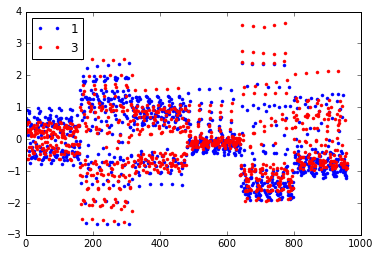

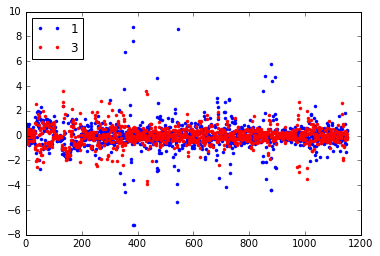

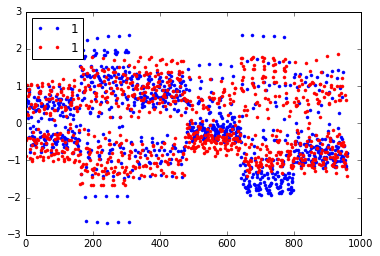

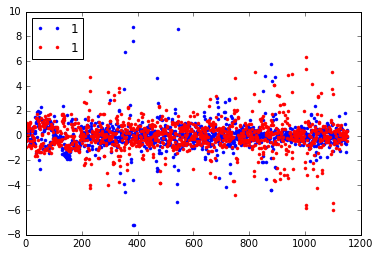

In [28]:
#f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2)
ax1, ax2, ax3, ax4 = (plt.subplots()[1] for i in range(4))
diff_label = np.where(trY != trY[0])[0][1]
#ax1 = fig.add_subplot(111)
ax1.plot(trXadj[0], c='b', marker='.', linestyle='', label=trY[0])
ax1.plot(trXadj[diff_label], c='r', marker='.', linestyle='', label=trY[diff_label])
ax1.legend(loc=2)
#ax2 = fig.add_subplot(212)
ax2.plot(trXrff[0], c='b', marker='.', linestyle='', label=trY[0])
ax2.plot(trXrff[diff_label], c='r', marker='.', linestyle='', label=trY[diff_label])
ax2.legend(loc=2)
same_label = np.where(trY == trY[0])[0][1]
#ax3 = fig.add_subplot(321)
ax3.plot(trXadj[0], c='b', marker='.', linestyle='', label=trY[0])
ax3.plot(trXadj[same_label], c='r', marker='.', linestyle='', label=trY[same_label])
ax3.legend(loc=2)
#ax4 = fig.add_subplot(422)
ax4.plot(trXrff[0], c='b', marker='.', linestyle='', label=trY[0])
ax4.plot(trXrff[same_label], c='r', marker='.', linestyle='', label=trY[same_label])
ax4.legend(loc=2)
plt.show()
# no missing data
# todo riffle
# look at classifier selection ppt
# below is definately just 2d

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO use cross_val_score

# ovo multi-classification, rbf
if sklearn.__version__ >= '0.18':
    print('warning, not ovo comparison')
svm = SVC(C=1.0)
svm.fit(trXadj, trY)
print('svm Orig accuracies: train {} test {}'.format(svm.score(trXadj, trY), svm.score(teXadj, teY)))
svm.fit(trXrff, trY)
print('svm Red accuracies: train {} test {}'.format(svm.score(trXrff, trY), svm.score(teXrff, teY)))

from sklearn.linear_model import LogisticRegressionCV
reg = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', max_iter=5000, n_jobs=8, cv=8)
reg.fit(trXadj, trY)
print('softmax Orig accuracies: train {} test {}'.format(reg.score(trXadj, trY), reg.score(teXadj, teY)))
reg.fit(trXrff, trY)
print('softmax Orig accuracies: train {} test {}'.format(reg.score(trXrff, trY), reg.score(teXrff, teY)))

svm Orig accuracies: train 0.98 test 0.72
svm Red accuracies: train 0.9833333333333333 test 0.53


In [ ]:
Ngnb = SVC(probability=True)
stumps = AdaBoostClassifier(n_estimators=30, base_estimator=gnb)
stumps.fit(trXadj, trY)
print('Orig accuracies: train {} test {}'.format(stumps.score(trXadj, trY), stumps.score(teXadj, teY)))
stumps.fit(trXred, trY)
print('Red accuracies: train {} test {}'.format(stumps.score(trXred, trY), stumps.score(teXred, teY)))

In [ ]:
v = trXred[0]
def sqmat(x):
    tx = x.reshape((1, len(x)))
    xt = x.reshape((len(x), 1))
    return np.dot(xt, tx).reshape(len(x) * len(x))
sq = np.array([sqmat(x) for x in trXred])
sqt = np.array([sqmat(x) for x in teXred])
print(sq.shape, sqt.shape)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(sq, trY)
gnb.score(sqt, teY)
svm.fit(sq, trY)
print('Accuracies: train {} test {}'.format(svm.score(sq, trY), svm.score(sqt, teY)))

In [ ]:
from sklearn.cross_validation import StratifiedKFold

trXadj = trXred
teXadj = teXred

def avg_cv_acc(classifier, K):
    skf = StratifiedKFold(trY,n_folds=K)
    acc = 0
    for (train_index, test_index) in skf:
        trXcv, trYcv = trXadj[train_index], trY[train_index]
        teXcv, teYcv = trXadj[test_index], trY[test_index]
        classifier.fit(trXcv, trYcv)
        acc += classifier.score(teXcv, teYcv)
    return acc / K

def logRange(lo, hi): return [10 ** i for i in range(lo, hi)]
gammas = [x / len(trX) for x in logRange(-3, 3)]
Cs = logRange(-3, 3)
kernels = ['rbf', 'linear'] # TODO others
hypers = itertools.product(Cs, kernels, gammas)
hypers = ((x[0], x[1], 0) if x[1] == 'linear' else x for x in hypers)
hypers = list(k for k, g in itertools.groupby(hypers))

def make_svc(tup): return SVC(C=tup[0], kernel=tup[1], gamma=tup[2])
FOLDS = 10
def test_svc(tup):
    svm = make_svc(tup)
    acc = avg_cv_acc(svm, FOLDS)
    return acc, tup

        
nproc = 4
best = -np.inf, None
        
proc, real = time.clock(), time.time()
with Parallel(n_jobs=nproc, backend='threading') as parallel:
    amt_done = 0
    for chunk in itertools.chain([[]], chunks(hypers, nproc)):
        if chunk:
            local = max(parallel(delayed(test_svc)(i) for i in chunk))
            best = max(best, local)
        width = 70
        amt_done += len(chunk)
        frac_done = int(amt_done / len(hypers) * width)
        print(('\r[' + '-' * frac_done + ' ' * (width - frac_done)
               + '] {:0' + str(len(str(len(hypers))))
               + 'd}/{} ({}x parallel)').format(amt_done, len(hypers), nproc), end='')
        sys.stdout.flush()
proc = time.clock() - proc
real = time.time() - real

best_acc, best_params = best
svm = make_svc(best_params)
print('\nDone with CV for {}-size hyper grid in {:02f}s (proc:real {:02f})'.format(
        len(hypers), real, proc / real))

print('Accuracies: cv {} (best C = {}, kernel = {}, gamma = {:03g})'.format(
    best_acc, *best_params))
svm.fit(trXadj, trY)
print('  re-trained test {}'.format(svm.score(teXadj, teY)))

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.ocean):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(confusion_matrix(teY, svm.predict(teXadj)))

In [ ]:
# Stanford mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# This requires a new convex program formulation, unsupported within-python.

In [ ]:
class DummyPredictor:
    def __init__(self, res):
        self._res = res
    def predict(self, X):
        Y = np.empty([len(X), 1])
        Y.fill(self._res)
        return Y
        
def find_best(subsets, X, origY, C):
    best_accuracy, best_classifier, best_set = -np.inf, None, None
    val = int(0.8 * len(X))
    for subset in subsets:
        Y = np.array([y in subset for y in origY])
        svm = SVC(C=C).fit(X[:val], Y[:val])
        acc = svm.score(X[val:], Y[val:])
        if acc > best_accuracy:
            best_accuracy = acc
            best_classifier = svm
            best_set = subset
    return best_accuracy, best_classifier, best_set
    
def best_subset_finder(labels, C=1.0):
    assert len(labels) > 0
    if len(labels) == 1:
        return {}, DummyPredictor(next(iter(labels))), {}
    if len(labels) == 2:
        return {}, SVC(C=C).fit(trXadj, trY), {}
    
    subsets = []
    for i in range(1, len(labels) // 2 + 1):
        for subset in itertools.combinations(labels, i):
            subsets.append(subset)
    p = np.random.permutation(len(trXadj))
    pX = trXadj[p]
    pY = trY[p]
    
    nproc = 4
    print('  Launching {} parallel tasks for {} problems.'.format(nproc, len(subsets)))
    sys.stdout.flush()
    np.random.shuffle(subsets)
    
    best_parallel = Parallel(n_jobs=2, backend='threading') \
        (delayed(find_best)(i, pX, pY, C) for i in chunks(subsets, max(len(subsets) // nproc, 1)))
    best_accuracy, best_set, best_classifier = -np.inf, None, None
    for job_best_acc, job_best_classifier, job_best_set in best_parallel:
         if job_best_acc > best_accuracy:
             best_accuracy = job_best_acc
             best_classifier = job_best_classifier
             best_set = set(job_best_set)
         
    other = labels - best_set
    print('  Split on 0/1 for {} vs {}, validation acc {}'.format(
        best_set, other, best_accuracy))
    sys.stdout.flush()
    assert best_classifier
    return best_set, best_classifier, other

class DTree(object):
    def __init__(self, classifier, lset, rset):
        self.lset = lset
        self.rset = rset
        self.left = None
        self.right = None
        self.classifier = classifier

def binary_dtree(labels, C=10.0, debug_print_level=None):
    dbp = debug_print_level
    if dbp: print('Level {}'.format(dbp))
    left, svm, right = best_subset_finder(labels)
    if not left: assert not right
    x = DTree(svm, left, right)
    if not left: return x
    x.left = binary_dtree(left, C=(C * len(left) / len(labels)),
                          debug_print_level=(dbp + '0' if dbp else None))
    x.right = binary_dtree(right, C=(C * len(right) / len(labels)),
                           debug_print_level=(dbp + '1' if dbp else None))
    return x

In [ ]:
bdt = binary_dtree(set(trY), C=10.0, debug_print_level='r')

In [ ]:
#What if we retrain on the whole training dataset?
def dtree_predict(dt, x):
    y = dt.classifier.predict([x])[0]
    if not dt.left: return y
    subtree = dt.left if y else dt.right
    return dtree_predict(subtree, x)

def vec_dtree_predict(dt, X):
    return np.array([dtree_predict(dt, x) for x in X])

np.sum(vec_dtree_predict(bdt, teXadj) == teY) / len(teY)